## What is Resume Screening?

Hiring the right talent is a challenge for all businesses. This challenge is magnified by the high volume of applicants if the business is labour-intensive, growing, and facing high attrition rates.


An example of such a business is that IT departments are short of growing markets. In a typical service organization, professionals with a variety of technical skills and business domain expertise are hired and assigned to projects to resolve customer issues. This task of selecting the best talent among many others is known as Resume Screening.

Typically, large companies do not have enough time to open each CV, so they use machine learning algorithms for the Resume Screening task.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv('data/UpdatedResumeDataSet.csv',encoding='utf-8')

In [14]:
data

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


Now let’s have a quick look at the categories of resumes present in the dataset:

In [22]:
print('Displaying the unique categoreis in resume and counts:')
print(data['Category'].value_counts())

Displaying the unique categoreis in resume and counts:
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


<AxesSubplot: xlabel='count', ylabel='Category'>

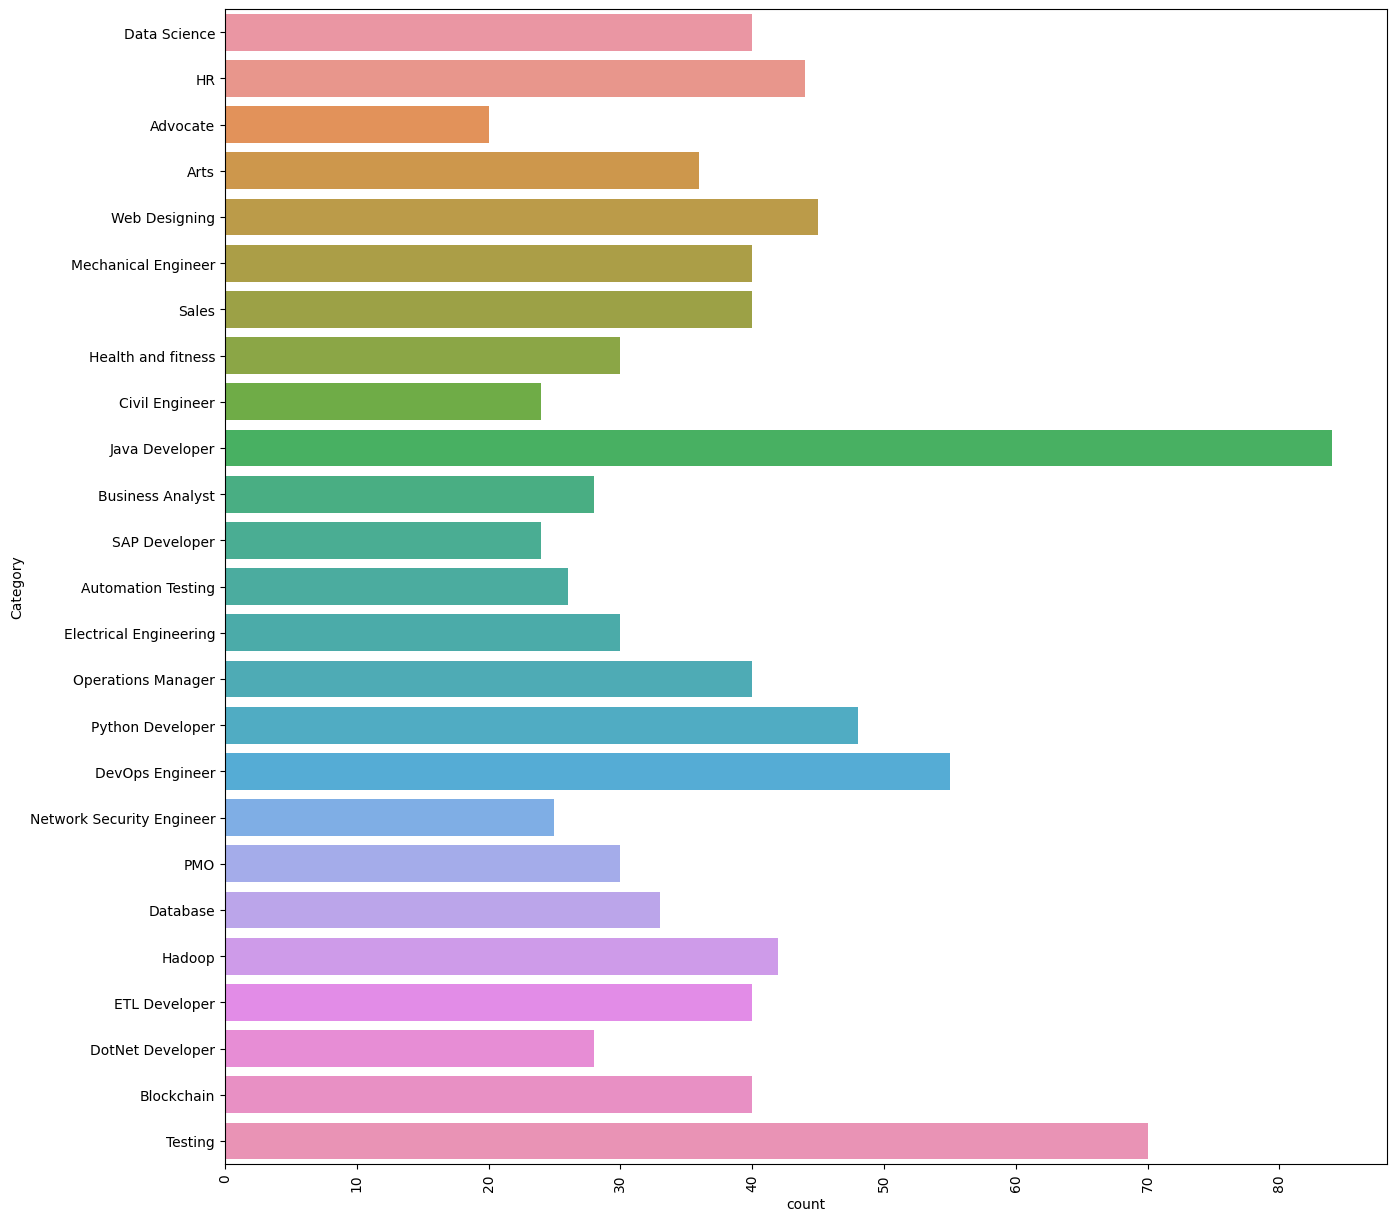

In [24]:
import seaborn as sns
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y='Category',data = data)

Now let’s visualize the distribution of categories:

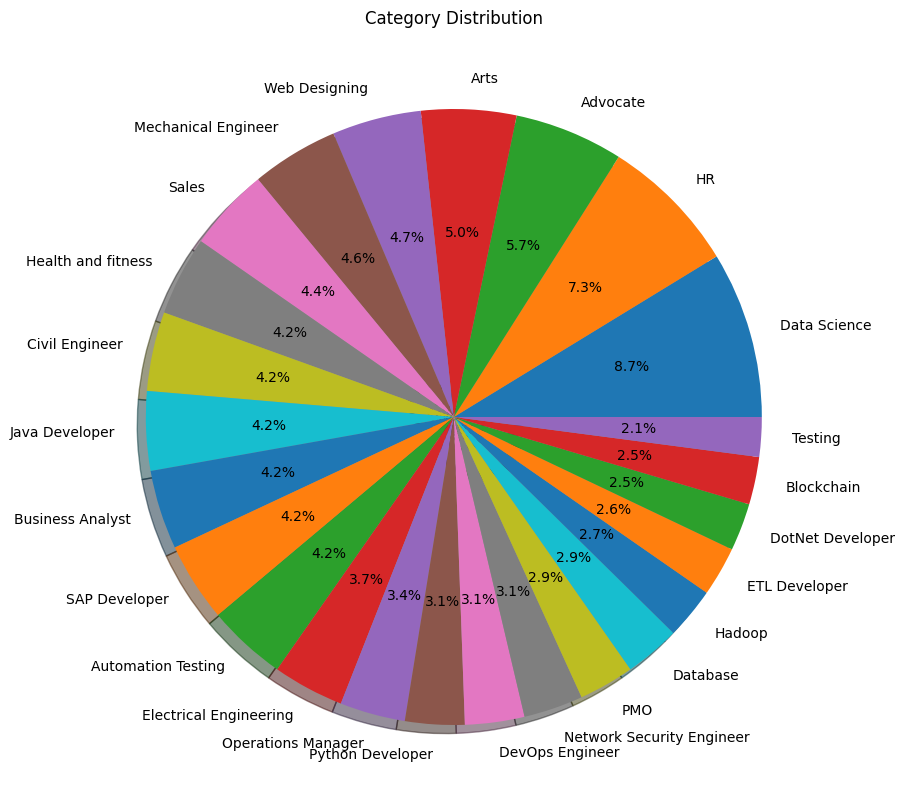

In [56]:
targetCounts = data['Category'].value_counts()
targetLabels = data['Category'].unique()
plt.figure(figsize=(10,10))
plt.title('Category Distribution')
source_pie = plt.pie(targetCounts,labels = targetLabels,autopct='%1.1f%%', shadow=True )
plt.show()

Now I will create a helper function to remove the URLs, hashtags, mentions, special letters, and punctuations:

In [57]:
import re
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s',' ',resumeText) #removing urls
    resumeText = re.sub('RT|cc',' ',resumeText) #remove RT and cc
    resumeText = re.sub('#\S*',' ',resumeText) #removing hashtags
    resumeText = re.sub('@\S+', ' ',resumeText) #removing mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-.<=>?@[\]^_`{|}~"""), ' ',resumeText) #removing punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ',resumeText)
    resumeText = re.sub('\s+',' ',resumeText) #Removing extra whitespaces /Spliting words
    return resumeText

data['cleaned_resume'] = data['Resume'].apply(lambda x:cleanResume(x))

the next task is to have a look at the Wordcloud. A Wordcloud represents the most numbers of words larger and vice versa

[nltk_data] Downloading package stopwords to punkz...
[nltk_data]   Package stopwords is already up-to-date!


[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Maharashtra', 166), ('6', 164), ('Skill', 160), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('India', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('application', 84), ('A', 80), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('Management', 74), ('projects', 74), ('Technologies', 72), ('Used', 72)]


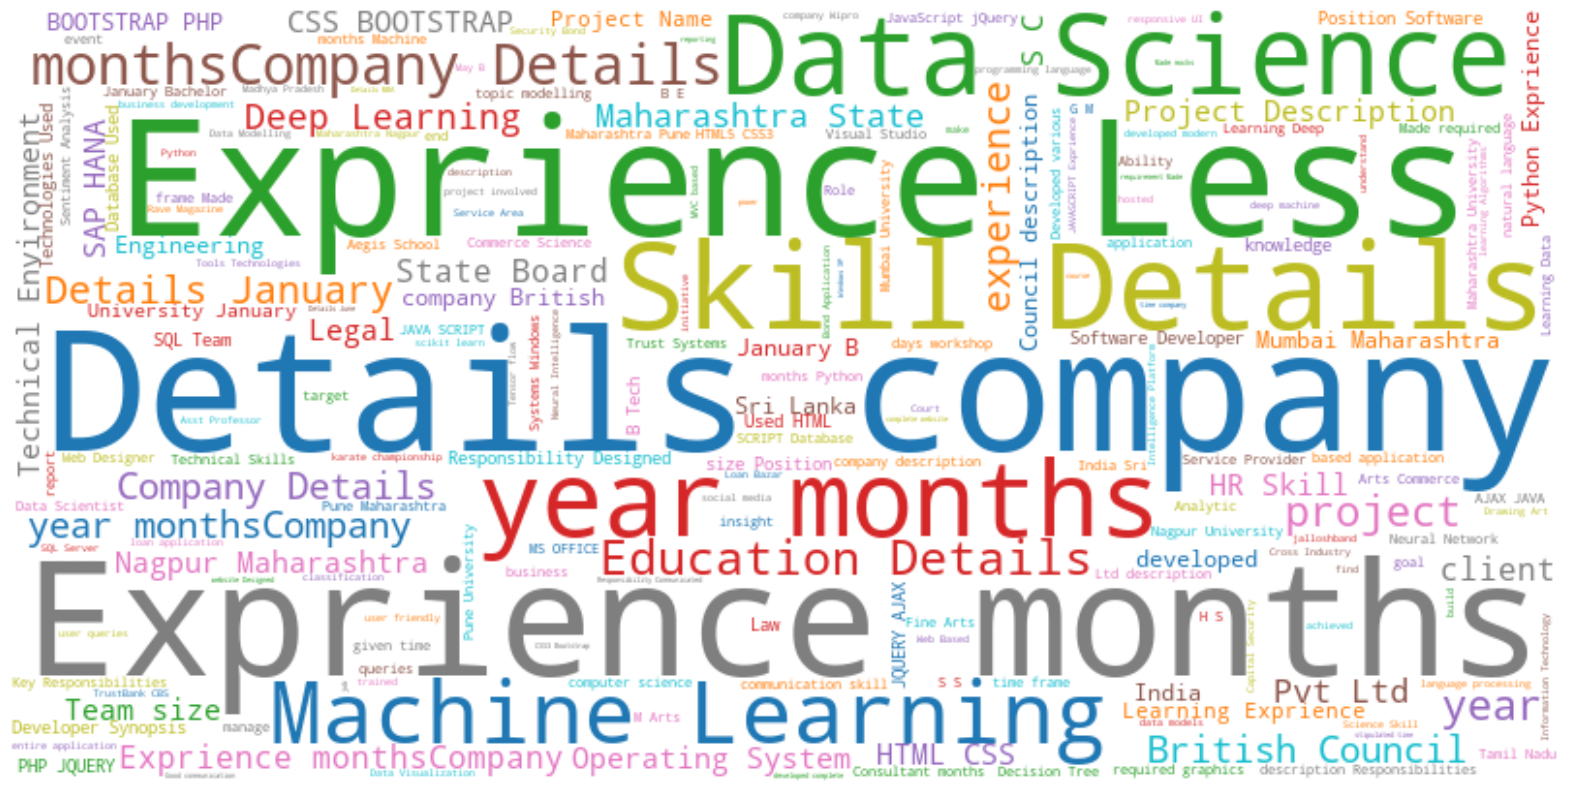

In [83]:
import nltk
nltk.download('stopwords','punkz')
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud

stopwords = set(stopwords.words('english')+['``',"''"])
totalwords = []
sentences = data['Resume'].values
cleanedSentences = ""
for i in range(0,160):
    cleanedText = cleanResume(sentences[i])
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in stopwords and word not in string.punctuation:
            totalwords.append(word)

word_freq_dict = nltk.FreqDist(totalWords)
mostCommon = word_freq_dict.most_common(50)
print(mostCommon)

wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(cleanedSentences)
plt.figure(figsize=(20,20))
plt.imshow(wc,interpolation= 'bilinear')
plt.axis('off')
plt.show()

Now I will convert these words into categorical values:

In [95]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Category']
encoder = LabelEncoder()
for i in var_mod:
    data[i] = encoder.fit_transform(data[i])
print(data['Category'])

0       6
1       6
2       6
3       6
4       6
       ..
957    23
958    23
959    23
960    23
961    23
Name: Category, Length: 962, dtype: int64


## Training Machine Learning Model for Resume Screening

Now the next step in the process is to train a model for the task of Resume Screening. Here I will use the one vs the rest classifier;

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

text = data['cleaned_resume'].values
target = data['Category'].values

word_vectorizer = TfidfVectorizer(max_features=1500)
word_vectorizer.fit(text)
word_features = word_vectorizer.transform(text)

print('feature completed......')

X_train, X_test, y_train, y_test = train_test_split(word_features,target,random_state=0,test_size=0.2)
print(X_train.shape)
print(y_test.shape)


feature completed......
(769, 1500)
(193,)


Now let’s train the model and print the classification report:

In [113]:
classifier = OneVsRestClassifier(KNeighborsClassifier())
classifier.fit(X_train, y_train)
prediction = classifier.predict(X_test)

print('Accuracy of KNN Classifier on training data: {:.2f}'.format(classifier.score(X_train,y_train)))
print('Accuracy of KNN Classifier on test data: {:.2f}'.format(classifier.score(X_test,y_test)))

print("\n Classification report for classifier - %s: \n %s\n" % ( classifier, metrics.classification_report(y_test, prediction)))


Accuracy of KNN Classifier on training data: 0.99
Accuracy of KNN Classifier on test data: 0.98

 Classification report for classifier - OneVsRestClassifier(estimator=KNeighborsClassifier()): 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      0.78      0.88         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00      